<h1>Machine Learning - Test NoteBook</h1>

<h2>All import </h2>

In [267]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix




<h3> - Read CSV with pandas </h">

In [268]:
df = pd.read_csv('datasetAvantML.csv')
max_per_class = 5000
for rating in range(1,6):
    df_rating = df[df['Rating'] == rating]
    if len(df_rating) > max_per_class:
        df = df.drop(df_rating.index[max_per_class:])

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 25139
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Content          25000 non-null  object 
 1   Rating           25000 non-null  int64  
 2   likes            25000 non-null  int64  
 3   Year_Month       25000 non-null  object 
 4   polarity         25000 non-null  float64
 5   subjectivity     25000 non-null  float64
 6   locations        1080 non-null   object 
 7   polarity_words   24003 non-null  object 
 8   word_count       25000 non-null  int64  
 9   days_diff        25000 non-null  int64  
 10  Content_cleaned  24921 non-null  object 
 11  punctuation      25000 non-null  object 
 12  tokenized        25000 non-null  object 
 13  lemmatized       25000 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 2.9+ MB


In [270]:
# Étape 1: Créer une colonne temporaire qui compte chaque type de ponctuation
punctuation_stats = df["punctuation"].apply(lambda x: Counter(x))

# Étape 2 : Ajouter les nouvelles colonnes tout en conservant 'punctuation'
df["punctuation_count"] = punctuation_stats.apply(lambda x: sum(x.values()))  # Total des signes de ponctuation
df["exclamation_count"] = punctuation_stats.apply(lambda x: x.get("!", 0))
df["question_count"] = punctuation_stats.apply(lambda x: x.get("?", 0))
df["comma_count"] = punctuation_stats.apply(lambda x: x.get(",", 0))

# Étape 3 : Calcul de la corrélation entre la ponctuation et le 'Rating'
correlation = df["punctuation_count"].corr(df["Rating"])
print(f"📊 Corrélation entre 'punctuation_count' et 'Rating' : {correlation}")

# Vérification finale
print(df[["punctuation", "punctuation_count", "exclamation_count", "question_count", "comma_count"]].head())

df["Content_cleaned"] = df["Content_cleaned"].fillna("") # Remplacer les valeurs manquantes par une chaîne vide

📊 Corrélation entre 'punctuation_count' et 'Rating' : -0.29485120083726246
            punctuation  punctuation_count  exclamation_count  question_count  \
0            [',', '.']                 10                  0               0   
1                 ['.']                  5                  0               0   
2  ['’', '.', '.', '.']                 20                  0               0   
3            ['’', '.']                 10                  0               0   
4       ['’', '.', '.']                 15                  0               0   

   comma_count  
0            2  
1            0  
2            3  
3            1  
4            2  


In [271]:
df.drop(["tokenized","Content_cleaned","punctuation_count","locations"], axis=1, inplace=True)


In [272]:
df.loc[df["lemmatized"] == "[]", ["Content", "lemmatized"]].to_clipboard()
# TODO c'est étrange que la lemmatisation ait des valeurs vides,notamment avec des commentaires comme : "I love Nebraska Furniture Mart"


In [273]:
df.drop(df.index[df["lemmatized"] == "[]"], axis=0, inplace=True) # On drop les lignes lemmatisées vides


<h3>Vectorized</h3>

In [274]:

y = df["Rating"].values  

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Rating"]), y, test_size=0.2, random_state=42)

In [275]:


# Initialisation du vectorizer TF-IDF
min_df = 15
vectorizer_tfidf = TfidfVectorizer(min_df=min_df, stop_words="english")

# Transformation en matrice TF-IDF
tfidf_matrix = vectorizer_tfidf.fit_transform(X_train["lemmatized"])
tfidf_matrix_test = vectorizer_tfidf.transform(X_test["lemmatized"])
# Conversion en liste et stockage dans `vectorized`
X_train["vectorized"] = list(tfidf_matrix.toarray())
X_test["vectorized"] = list(tfidf_matrix_test.toarray())

# Vérification
print(X_train[["vectorized"]].head())
print(X_test[["vectorized"]].head())

# TODO : réduire la vectorisation (limiter les features, optimiser sur les plus impactantes pour chaque classe etc...)
# TODO : notre vecotrize est adapté a l'ensemble de notre donnée, donc il est potentiellement entrainé sur notre donnée de test également ?

                                              vectorized
2629   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2116   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8069   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9237   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
15848  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                              vectorized
12612  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3053   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
24156  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4419   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4601   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


In [276]:
for dfi in [X_train, X_test]:
    dfi["vectorized_sum"] = dfi["vectorized"].apply(lambda x: sum(x))
    print(dfi[["vectorized_sum"]].head(10))

    total_tfidf_sum = sum(dfi["vectorized_sum"])
    print(f"📌 Somme totale de toutes les valeurs TF-IDF : {total_tfidf_sum}")

    print(f"📌 Nombre de lignes avec une somme TF-IDF nulle : {(dfi['vectorized_sum'] == 0).sum()} / {len(dfi)}")

       vectorized_sum
2629         1.000000
2116         3.038287
8069         2.951892
9237         3.924920
15848        1.721874
18676        5.983362
13256        3.774646
8879         2.113347
3491         2.851701
13901        1.672635
📌 Somme totale de toutes les valeurs TF-IDF : 58449.001304698555
📌 Nombre de lignes avec une somme TF-IDF nulle : 62 / 19924
       vectorized_sum
12612        1.920460
3053         2.428122
24156        1.979228
4419         2.412213
4601         1.406066
12370        2.850577
3989         3.235535
19511        2.849687
3808         1.725791
6030         1.413731
📌 Somme totale de toutes les valeurs TF-IDF : 14502.07707299655
📌 Nombre de lignes avec une somme TF-IDF nulle : 13 / 4981


In [277]:
print(type(X_train["vectorized"].iloc[0]))  # Doit être <class 'list'>
print(X_train["vectorized"].iloc[0])  # Doit afficher une liste de nombres

<class 'numpy.ndarray'>
[0. 0. 0. ... 0. 0. 0.]


In [278]:

# Convertir la colonne `vectorized` en un tableau NumPy correctement formaté
X_vectorized_train = np.vstack(X_train["vectorized"].values)
X_vectorized_test = np.vstack(X_test["vectorized"].values)

print("📌 Shape de X_vectorized test:", X_vectorized_test.shape)
print("📌 Shape de X_vectorized train:", X_vectorized_train.shape)

📌 Shape de X_vectorized test: (4981, 1640)
📌 Shape de X_vectorized train: (19924, 1640)


In [279]:
# Sélectionner uniquement les features numériques pertinentes
use_vectorize = True
use_daydiff = True
use_meta = True
explicative_columns = []
if use_vectorize:
    explicative_columns.append("vectorized_sum")
if use_meta:
    explicative_columns = ["polarity", "subjectivity", "word_count"]
if use_daydiff:
    explicative_columns.append("days_diff")
X_train = X_train[explicative_columns].values
X_test = X_test[explicative_columns].values
# Concaténer les features textuelles vectorisées avec les autres variables
if use_vectorize:
    X_train = np.hstack((X_vectorized_train, X_train))
    X_test = np.hstack((X_vectorized_test, X_test))

if use_meta:
    X_train
# X_final = X_vectorized

print("Shape de X_final :", X_train.shape)  # Doit être (n_samples, 28082 + nb_features_numériques)
variable_observations_ratio=X_train.shape[1]/X_train.shape[0]
print(f"Variables / Observations : {variable_observations_ratio*100:0.2f}%")

Shape de X_final : (19924, 1644)
Variables / Observations : 8.25%


<h3> Test ML </h3>

In [280]:
# --- INIT DES METRICS ---
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error, mean_absolute_error
import seaborn as sns
model_dict_5_class = dict() # a initialisé qu'une fois  qu'une fois pour le premier model testé
model_dict_2_class = dict()
def get_report_dict(y_test, y_pred):
    report_dict = dict()
    n_class = list(range(min(y_test), max(y_test)+1))
    n_class += ["macro avg"]
    report = classification_report(y_test, y_pred, output_dict=True)
    report_dict['Accuracy'] = report['accuracy']
    report_dict["RMSE"] = root_mean_squared_error(y_test, y_pred)
    report_dict["MAE"] = mean_absolute_error(y_test, y_pred)
    for classs in n_class:
        if type(classs) == int:
            mask_classs = y_test == classs
            y_test_classs = y_test[mask_classs]
            y_pred_classs = y_pred[mask_classs]
            report_dict[f"RMSE_class_{classs}"] = root_mean_squared_error(y_test_classs, y_pred_classs)
            report_dict[f"MAE_class_{classs}"] = mean_absolute_error(y_test_classs, y_pred_classs)
        classs = str(classs)
        report_dict[f'Precision_class_{classs}'] = report[classs]['precision']
        report_dict[f'Recall_class_{classs}'] = report[classs]['recall']
        report_dict[f'F1_class_{classs}'] = report[classs]['f1-score']
    return(report_dict)

def model_result_diplay_sub(y_test, y_pred, model_dict, model_i):
    print(classification_report(y_test, y_pred))
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(min(y_pred), max(y_pred)+1), yticklabels=range(min(y_test), max(y_test)+1))
    model_dict[model_i] = get_report_dict(y_test, y_pred)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(model_i)

def model_result_diplay(y, y_pred, model_i):
    for mode in range(2):
        if mode==1:
            model_dict = model_dict_2_class
            yl = list()
            for i, yi in enumerate([y, y_pred]):
                yl.append(yi.copy())
                mask1 = (yl[i] == 5) | (yl[i] == 4)
                mask0 = (yl[i] == 3) | (yl[i] == 2) | (yl[i] == 1)
                yl[i][mask1] = 1
                yl[i][mask0] = 0

        else:
            yl = list()
            yl.append(y)
            yl.append(y_pred)
            model_dict = model_dict_5_class
        model_result_diplay_sub(yl[0], yl[1], model_dict, f"{model_i}")
        



              precision    recall  f1-score   support

           1       0.54      0.52      0.53       978
           2       0.42      0.48      0.45      1026
           3       0.39      0.32      0.35      1016
           4       0.41      0.33      0.37       961
           5       0.61      0.75      0.67      1000

    accuracy                           0.48      4981
   macro avg       0.47      0.48      0.47      4981
weighted avg       0.47      0.48      0.47      4981

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      3020
           1       0.81      0.83      0.82      1961

    accuracy                           0.86      4981
   macro avg       0.85      0.85      0.85      4981
weighted avg       0.86      0.86      0.86      4981



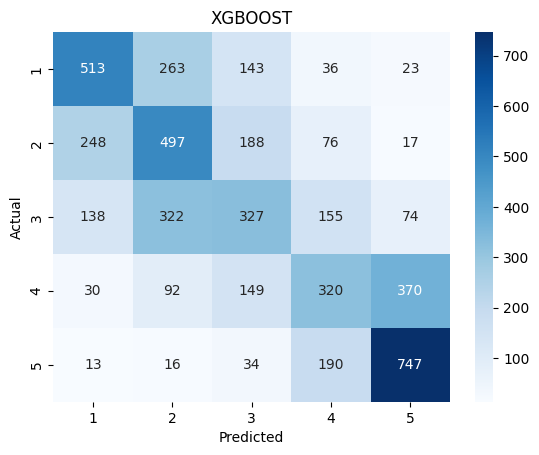

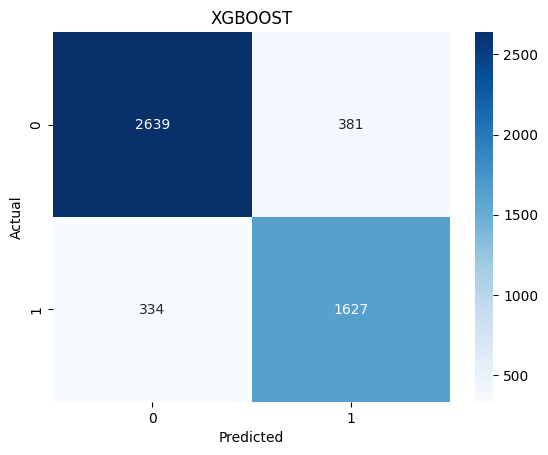

In [282]:
# TEST 2
model_i = "XGBOOST" # nom du model

# ---- LA VOUS FAITES CE QUE VOUS VOULEZ MAIS A LA FIN IL FAUT y_pred
from xgboost import XGBClassifier
model_xgb = XGBClassifier(objective="multi:softmax", num_class=5, n_estimators=100, random_state=42)
y_train -= 1  # XGBoost needs classes starting from 0
model_xgb.fit(X_train, y_train)
y_train += 1
y_pred_xgb = model_xgb.predict(X_test)
y_pred_xgb += 1
y_pred = y_pred_xgb
 # --- On affiche les metrics par model----
model_result_diplay(y_test, y_pred, model_i)


In [283]:

vecto_list = list(vectorizer_tfidf.get_feature_names_out())
full_columns = list()
if use_vectorize:
    full_columns += vecto_list
full_columns += explicative_columns
feat_importance = pd.DataFrame(model_xgb.feature_importances_, index=full_columns, columns=["importance"]).sort_values(by="importance", ascending=False)
vecto_usefull = feat_importance[feat_importance.index.isin(vecto_list + ["vectorized_sum"])].sum()
vecto_usefull.index = ["From Vecto"]
vecto_usefull.name = "importance"
feat_importance = pd.concat([feat_importance, vecto_usefull], ignore_index=False)
feat_importance.sort_values(by="importance", ascending=False, inplace=True)
display(feat_importance.head(10))


,importance
From Vecto,0.985771
polarity,0.008212
cancel,0.007505
lie,0.006042
short,0.005415
terrible,0.004385
file,0.004283
claim,0.003967
horrible,0.003754
personable,0.003683


              precision    recall  f1-score   support

           1       0.80      0.75      0.78      4011
           2       0.67      0.78      0.72      3964
           3       0.73      0.64      0.68      3962
           4       0.74      0.59      0.66      4012
           5       0.71      0.88      0.79      3975

    accuracy                           0.73     19924
   macro avg       0.73      0.73      0.73     19924
weighted avg       0.73      0.73      0.73     19924

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     11937
           1       0.89      0.90      0.90      7987

    accuracy                           0.92     19924
   macro avg       0.91      0.91      0.91     19924
weighted avg       0.92      0.92      0.92     19924



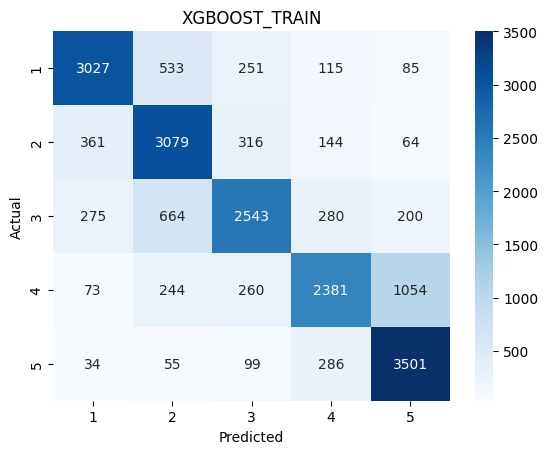

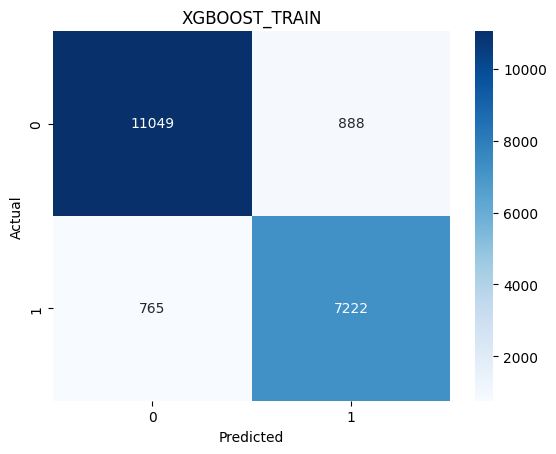

In [284]:
# Train plot
y_pred_train = model_xgb.predict(X_train)
y_pred_train += 1

model_result_diplay(y_train, y_pred_train, model_i+"_TRAIN")

g:\Mon Drive\Perso\Formation\Projet_Supply_Chain\script\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.88      0.91      0.89      3020
           1       0.85      0.81      0.83      1961

    accuracy                           0.87      4981
   macro avg       0.86      0.86      0.86      4981
weighted avg       0.87      0.87      0.87      4981



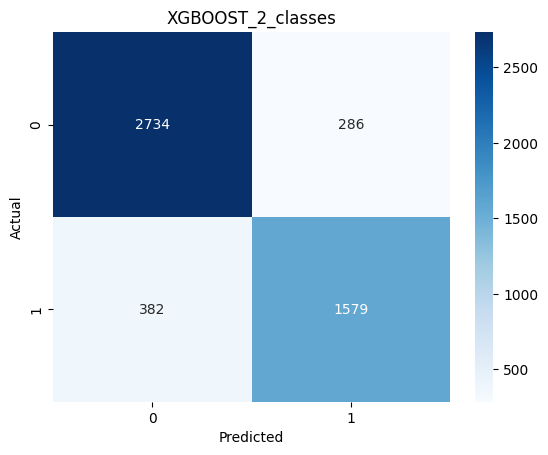

In [285]:
# TEST 2 XGBOOST 2 classes
model_i = "XGBOOST_2_classes" # nom du model

# ---- LA VOUS FAITES CE QUE VOUS VOULEZ MAIS A LA FIN IL FAUT y_pred
yl = list()
for i, yi in enumerate([y_train, y_test]):
    yl.append(yi.copy())
    mask1 = (yl[i] == 5) | (yl[i] == 4)
    mask0 = (yl[i] == 3) | (yl[i] == 2) | (yl[i] == 1)
    yl[i][mask1] = 1
    yl[i][mask0] = 0

#  Pour gérer le désequilibre des classes
scale_pos_weight = len(yl[0][yl[0] == 0]) / len(yl[0][yl[0] == 1])

# Initialisation du modèle avec le paramètre ajusté
model_xgb_2_class = XGBClassifier(objective="multi:softmax", num_class=2, n_estimators=100, random_state=42, scale_pos_weight=scale_pos_weight)

model_xgb_2_class.fit(X_train, yl[0])
y_pred_xgb_2_class = model_xgb_2_class.predict(X_test)
y_pred = y_pred_xgb_2_class
 # --- On affiche les metrics par model----

model_result_diplay_sub(yl[1], y_pred, model_dict_2_class, model_i)


              precision    recall  f1-score   support

           1       0.49      0.56      0.52       978
           2       0.41      0.44      0.43      1026
           3       0.36      0.28      0.31      1016
           4       0.40      0.32      0.36       961
           5       0.59      0.70      0.64      1000

    accuracy                           0.46      4981
   macro avg       0.45      0.46      0.45      4981
weighted avg       0.45      0.46      0.45      4981

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      3020
           1       0.81      0.81      0.81      1961

    accuracy                           0.85      4981
   macro avg       0.84      0.84      0.84      4981
weighted avg       0.85      0.85      0.85      4981



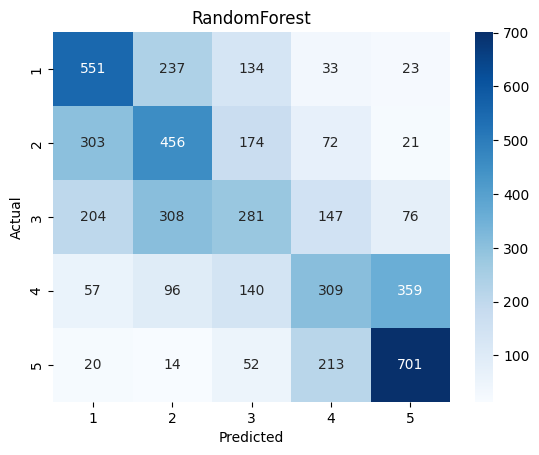

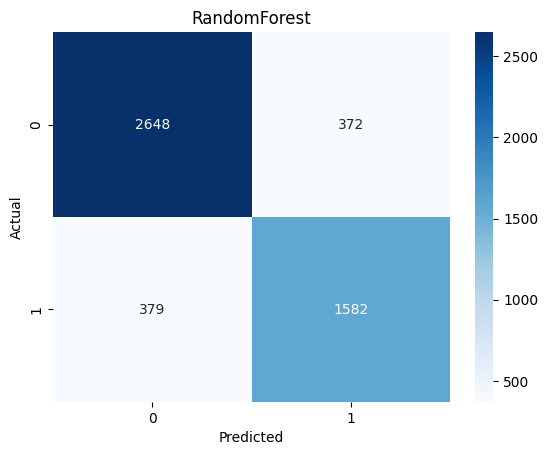

In [ ]:
# TEST 3
model_i = "RandomForest" # nom du model

# ---- LA VOUS FAITES CE QUE VOUS VOULEZ MAIS A LA FIN IL FAUT y_pred
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

model_result_diplay(y_test, y_pred, model_i)

              precision    recall  f1-score   support

           1       0.60      0.45      0.51       978
           2       0.39      0.52      0.45      1026
           3       0.35      0.36      0.36      1016
           4       0.39      0.33      0.36       961
           5       0.64      0.67      0.65      1000

    accuracy                           0.47      4981
   macro avg       0.48      0.47      0.47      4981
weighted avg       0.48      0.47      0.47      4981

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      3020
           1       0.84      0.79      0.81      1961

    accuracy                           0.86      4981
   macro avg       0.85      0.85      0.85      4981
weighted avg       0.86      0.86      0.86      4981



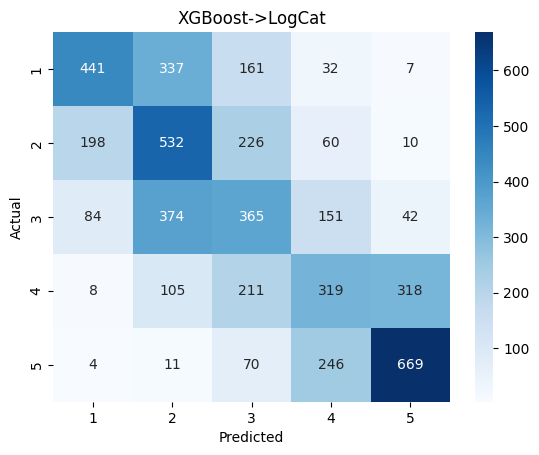

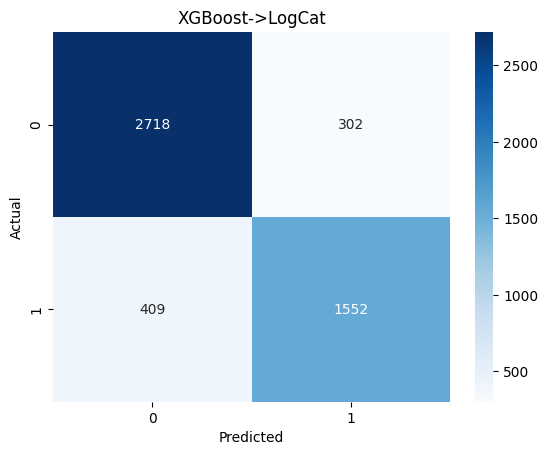

In [298]:
# TEST 4
model_i = "XGBoost->LogCat" # nom du model

# ---- LA VOUS FAITES CE QUE VOUS VOULEZ MAIS A LA FIN IL FAUT y_pred
from mord import LogisticAT  




model_xgb = XGBClassifier(objective="multi:softprob", num_class=5, n_estimators=100, random_state=42)
y_train -= 1  
model_xgb.fit(X_train, y_train)
y_train += 1


train_probas = model_xgb.predict_proba(X_train) 
test_probas = model_xgb.predict_proba(X_test) 


model_ord = LogisticAT(alpha=0.1, max_iter=1000)
model_ord.fit(train_probas, y_train)

y_pred = model_ord.predict(test_probas)




model_result_diplay(y_test, y_pred, model_i)

C:\Users\Steffen\AppData\Local\Temp\ipykernel_29644\179685794.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(1,6), y=mean_probs,  ax=axes[i], palette="viridis")
C:\Users\Steffen\AppData\Local\Temp\ipykernel_29644\179685794.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(1,6), y=mean_probs,  ax=axes[i], palette="viridis")
C:\Users\Steffen\AppData\Local\Temp\ipykernel_29644\179685794.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(1,6), y=mean_probs,  ax=axes[i], palette="viridis")
C:\Users\Steffen\AppDa

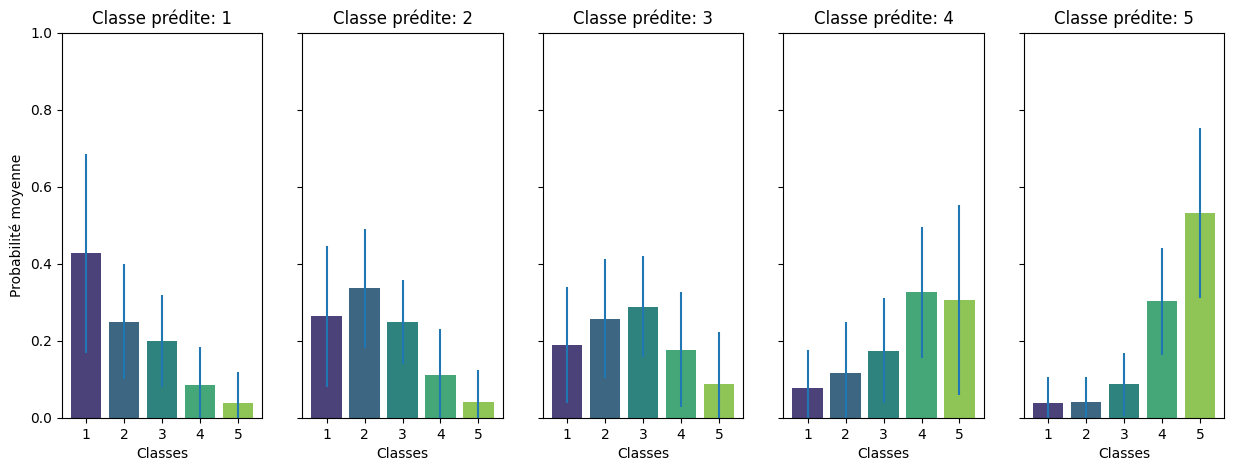

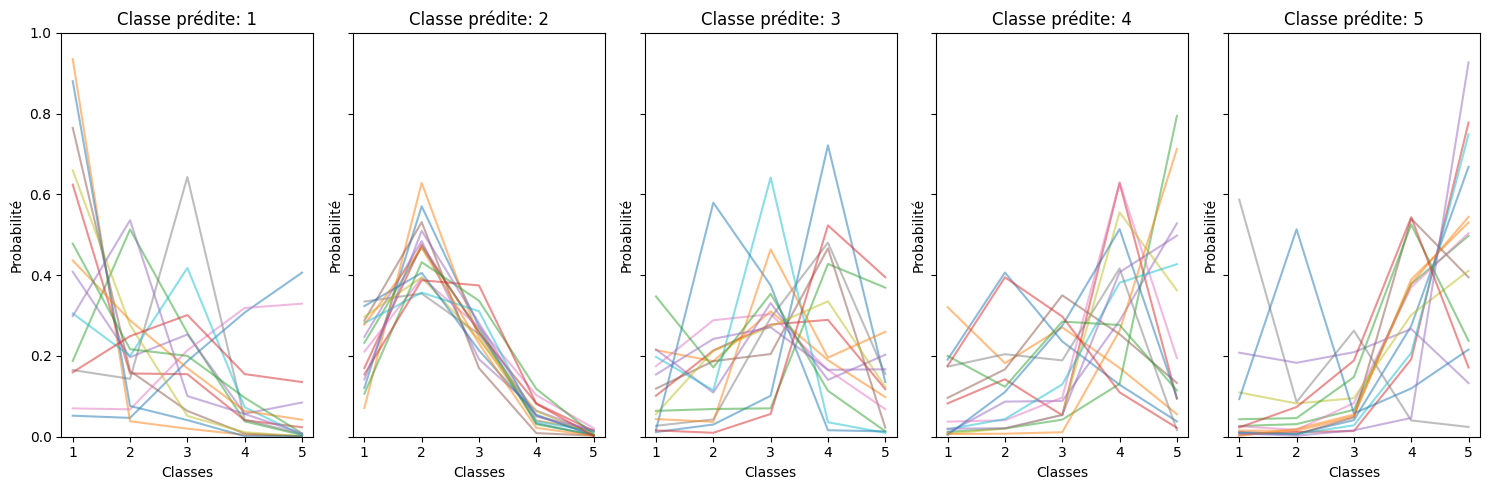

In [299]:
# Proba visuatlisation


y_test2 = y_test.copy()
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
for i, class_label in enumerate(range(1,6)):
    mask = y_test2 == class_label
    mean_probs = test_probas[mask].mean(axis=0)
    std_probs = test_probas[mask].std(axis=0)

    sns.barplot(x=range(1,6), y=mean_probs,  ax=axes[i], palette="viridis")
    axes[i].errorbar(range(0,5), mean_probs, yerr=std_probs, fmt='none')

    axes[i].set_title(f'Classe prédite: {class_label}')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Probabilité moyenne' if i == 0 else "")
    axes[i].set_ylim(0, 1)


fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
max_plot = 15
for i, class_label in enumerate(range(1,6)):
    mask = y_test2 == class_label
    y_plot = test_probas[mask]
    y_plot = y_plot[np.random.randint(0, y_plot.shape[0], max_plot), :]
    # mean_probs = test_probas[mask].mean(axis=0)
    # std_probs = test_probas[mask].std(axis=0)

    for j in range(y_plot.shape[0]):
        axes[i].plot(range(1,6), y_plot[j,:], alpha=0.5)
    axes[i].set_title(f'Classe prédite: {class_label}')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Probabilité')
    axes[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

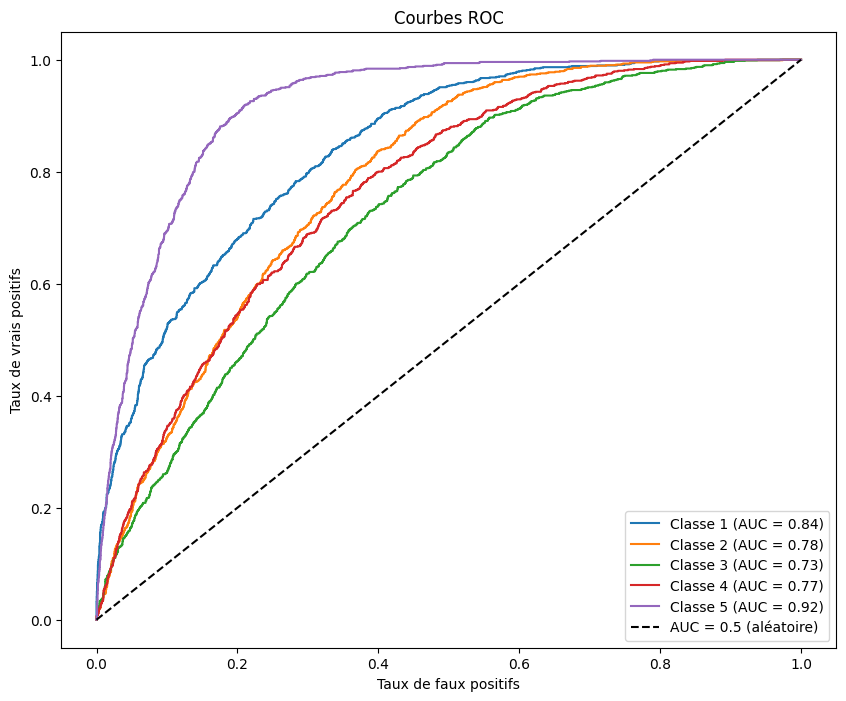

In [289]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_test2)

# Calculer la courbe ROC pour chaque classe
fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):  # Pour chaque classe
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], test_probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Visualiser les courbes ROC pour chaque classe
plt.figure(figsize=(10, 8))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='AUC = 0.5 (aléatoire)')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend(loc='lower right')
plt.show()

In [290]:
print(classification_report(y_test2, np.argmax(test_probas, axis=1)+1))


              precision    recall  f1-score   support

           1       0.54      0.52      0.53       978
           2       0.42      0.48      0.45      1026
           3       0.39      0.32      0.35      1016
           4       0.41      0.33      0.37       961
           5       0.61      0.75      0.67      1000

    accuracy                           0.48      4981
   macro avg       0.47      0.48      0.47      4981
weighted avg       0.47      0.48      0.47      4981



0.00% de threshold testés
1.29% de threshold testés
2.57% de threshold testés
3.86% de threshold testés
5.14% de threshold testés
6.43% de threshold testés
7.72% de threshold testés
9.00% de threshold testés
10.29% de threshold testés
11.57% de threshold testés
12.86% de threshold testés
14.15% de threshold testés
15.43% de threshold testés
16.72% de threshold testés
18.00% de threshold testés
19.29% de threshold testés
20.58% de threshold testés
21.86% de threshold testés
23.15% de threshold testés
24.43% de threshold testés
25.72% de threshold testés
27.01% de threshold testés
28.29% de threshold testés
29.58% de threshold testés
30.86% de threshold testés
32.15% de threshold testés
33.44% de threshold testés
34.72% de threshold testés
36.01% de threshold testés
37.29% de threshold testés
38.58% de threshold testés
39.87% de threshold testés
41.15% de threshold testés
42.44% de threshold testés
43.72% de threshold testés
45.01% de threshold testés
46.30% de threshold testés
47.58% de

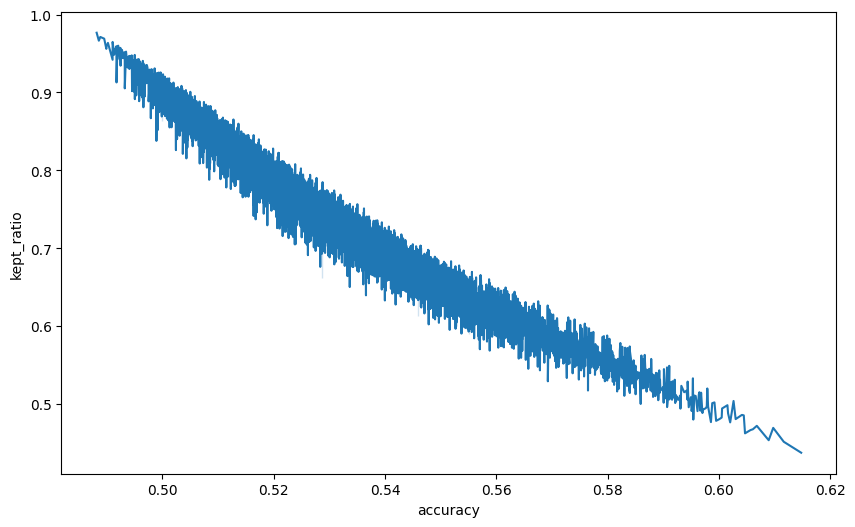

In [ ]:
import itertools
def adjust_classwise_thresholds_and_evaluate(probas, y_true, thresholds_list, list_mode=False, kept_th=0.8):
    """
    Teste plusieurs seuils pour chaque classe et conserve celui qui maximise l'accuracy,
    tout en excluant les prédictions -1 dans le calcul du classification report.
    """
    n_classes = probas.shape[1]
    if list_mode:
        best_thresholds = list()
        best_accuracy = list()
        best_y_pred_adjusted = None
        best_y_pred_kept_ratio = list()
    else: 
        best_thresholds = None
        best_accuracy = 0
        best_y_pred_adjusted = None
        best_y_pred_kept_ratio = None

    
    # Iterer sur toutes les combinaisons possibles de seuils pour chaque classe
    for i, thresholds in enumerate(thresholds_list):
        if i % 100 == 0:
            print(f"{i/len(thresholds_list)*100:.2f}% de threshold testés")
        y_pred_adjusted = np.zeros_like(y_true)  # Initialisation du tableau de prédictions ajustées
        for i in range(len(y_true)):
            max_prob = np.max(probas[i])  # Probabilité maximale
            class_idx = np.argmax(probas[i])  # Indice de la classe prédite
            
            # Appliquer le seuil spécifique à la classe prédite
            if max_prob >= thresholds[class_idx]:
                y_pred_adjusted[i] = class_idx  # La classe prédite est retenue
            else:
                y_pred_adjusted[i] = -1  # "Rejeté" si la probabilité est inférieure au seuil
        
        # Exclure les prédictions -1
        valid_indices = y_pred_adjusted != -1
        y_true_filtered = y_true[valid_indices]
        y_pred_adjusted_filtered = y_pred_adjusted[valid_indices]
        kept = sum(valid_indices)/len(valid_indices)
        # Calculer l'accuracy pour cette combinaison de seuils
        accuracy = accuracy_score(y_true_filtered, y_pred_adjusted_filtered)
        
        # Si l'accuracy est meilleure, on conserve cette combinaison
        if list_mode:
            best_accuracy.append(accuracy)
            best_thresholds.append(thresholds)
            best_y_pred_kept_ratio.append(kept)
        else:
            if (accuracy > best_accuracy) & (kept > kept_th):
                best_accuracy = accuracy
                best_thresholds = thresholds
                best_y_pred_adjusted = y_pred_adjusted
                best_y_pred_kept_ratio = kept


    return best_accuracy, best_thresholds, best_y_pred_adjusted, best_y_pred_kept_ratio



values = np.linspace(0.28,0.5, 6) # 1 sinon 3 c'est pas mal pour que ça aille vite
combinations = list(itertools.product(values, repeat=5))

if min(y_test2) != 0:
    y_test2 -= 1    

list_mode = True
best_accuracy, best_thresholds, best_y_pred_adjusted, kept_ratio = adjust_classwise_thresholds_and_evaluate(test_probas, y_test2, combinations, list_mode=list_mode)
if list_mode:
    list_df = pd.DataFrame({"accuracy": best_accuracy, "thresholds": best_thresholds, "kept_ratio": kept_ratio})
    list_df.sort_values(by="accuracy", ascending=False, inplace=True)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=list_df, x="accuracy", y="kept_ratio")
    plt.ylabel("Pourcentage de prédictions conservées")
else:
    print(f"Meilleure accuracy: {best_accuracy}")
    print(f"Meilleurs seuils: {best_thresholds}")
    print(f"On garde {kept_ratio*100:.2f}% des prédictions.")

# print(f"Pourcentage de prédictions conservées: {kept_ratio*100:.2f}%")

In [292]:
if not list_mode:
    print(classification_report(y_test, best_y_pred_adjusted))


In [293]:
combinations = [[0.83, 0.76, 0.72, 0.76, 0.91]]  # Exemple de seuils basés sur l'AUC
best_accuracy, best_thresholds, best_y_pred_adjusted, kept_ratio = adjust_classwise_thresholds_and_evaluate(test_probas, y_test2, combinations, list_mode=False, kept_th=0)
print(f"on gardera {kept_ratio*100:.2f}% des prédictions")

# Calculer le rapport de classification avec les seuils ajustés
print(classification_report(y_test, best_y_pred_adjusted))

0.00% de threshold testés
on gardera 3.31% des prédictions
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       978
           2       0.00      0.00      0.00      1026
           3       0.20      0.00      0.01      1016
           4       0.14      0.00      0.01       961
           5       0.00      0.00      0.00      1000

    accuracy                           0.00      4981
   macro avg       0.05      0.00      0.00      4981
weighted avg       0.07      0.00      0.00      4981



g:\Mon Drive\Perso\Formation\Projet_Supply_Chain\script\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mon Drive\Perso\Formation\Projet_Supply_Chain\script\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Mon Drive\Perso\Formation\Projet_Supply_Chain\script\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

In [295]:
# Résumé de tous les models
dset = []
if use_vectorize:
    dset.append("vectorize")
if use_daydiff:
    dset.append("daydiff")
if use_meta:
    dset.append("meta")

dset = "_".join(dset)
report_df_2_class = pd.DataFrame(model_dict_2_class).T
display(report_df_2_class)
report_df_5_class = pd.DataFrame(model_dict_5_class).T
display(report_df_5_class)
report_df_2_class.to_csv(f'report/2_class_{max_per_class}_perclass_mindf_{min_df}_{dset}.csv')
report_df_5_class.to_csv(f'report/5_class_{max_per_class}_perclass_mindf_{min_df}_{dset}.csv')
feat_importance.to_csv(f'report/feat_importance_{max_per_class}_perclass_mindf_{min_df}_{dset}.csv')

,Accuracy,RMSE,MAE,RMSE_class_0,MAE_class_0,Precision_class_0,Recall_class_0,F1_class_0,RMSE_class_1,MAE_class_1,Precision_class_1,Recall_class_1,F1_class_1,Precision_class_macro avg,Recall_class_macro avg,F1_class_macro avg
XGBOOST,0.856455,0.378874,0.143545,0.355189,0.126159,0.887656,0.873841,0.880694,0.412700,0.170321,0.810259,0.829679,0.819854,0.848957,0.851760,0.850274
XGBOOST_TRAIN,0.917035,0.288037,0.082965,0.272746,0.074391,0.935246,0.925609,0.930403,0.309484,0.095781,0.890506,0.904219,0.897310,0.912876,0.914914,0.913856
XGBOOST_2_classes,0.865890,0.366210,0.134110,0.307737,0.094702,0.877407,0.905298,0.891134,0.441360,0.194799,0.846649,0.805201,0.825405,0.862028,0.855250,0.858270
RandomForest,0.849227,0.388295,0.150773,0.350968,0.123179,0.874794,0.876821,0.875806,0.439623,0.193269,0.809621,0.806731,0.808174,0.842207,0.841776,0.841990
xGboot->LogCat,0.857258,0.377813,0.142742,0.316228,0.100000,0.869204,0.900000,0.884334,0.456691,0.208567,0.837109,0.791433,0.813630,0.853156,0.845716,0.848982


,Accuracy,RMSE,MAE,RMSE_class_1,MAE_class_1,Precision_class_1,Recall_class_1,F1_class_1,RMSE_class_2,MAE_class_2,...,Recall_class_4,F1_class_4,RMSE_class_5,MAE_class_5,Precision_class_5,Recall_class_5,F1_class_5,Precision_class_macro avg,Recall_class_macro avg,F1_class_macro avg
XGBOOST,0.482634,1.058422,0.690624,1.249540,0.765849,0.544586,0.524540,0.534375,0.932936,0.622807,...,0.332986,0.368239,0.823408,0.358000,0.606824,0.747000,0.669655,0.473944,0.482156,0.474601
XGBOOST_TRAIN,0.729321,0.816199,0.380295,0.990103,0.428821,0.802918,0.754675,0.778049,0.679266,0.291877,...,0.593470,0.659740,0.657994,0.197484,0.713907,0.880755,0.788602,0.733113,0.729497,0.726397
RandomForest,0.461353,1.118371,0.742020,1.212579,0.711656,0.485463,0.563395,0.521533,0.964274,0.666667,...,0.321540,0.356196,0.931128,0.439000,0.594068,0.701000,0.643119,0.449798,0.461391,0.452072
xGboot->LogCat,0.466975,0.989201,0.668942,1.188304,0.800613,0.600000,0.450920,0.514886,0.857259,0.559454,...,0.331946,0.360656,0.830060,0.435000,0.639579,0.669000,0.653959,0.475837,0.465927,0.466379


In [296]:
for rnge, report_df in zip([range(1,6), range(0,2)], [report_df_5_class, report_df_2_class]):
    col_list = [f"RMSE_class_{i}" for i in rnge]
    display(report_df[col_list])

    col_list = [f"Precision_class_{i}" for i in rnge]
    display(report_df[col_list])

    col_list = [f"F1_class_{i}" for i in rnge]
    display(report_df[col_list])


,RMSE_class_1,RMSE_class_2,RMSE_class_3,RMSE_class_4,RMSE_class_5
XGBOOST,1.249540,0.932936,1.141987,1.097248,0.823408
XGBOOST_TRAIN,0.990103,0.679266,0.847242,0.857057,0.657994
RandomForest,1.212579,0.964274,1.245069,1.205261,0.931128
xGboot->LogCat,1.188304,0.857259,1.006377,1.030745,0.830060


,Precision_class_1,Precision_class_2,Precision_class_3,Precision_class_4,Precision_class_5
XGBOOST,0.544586,0.417647,0.388823,0.411840,0.606824
XGBOOST_TRAIN,0.802918,0.673005,0.733064,0.742670,0.713907
RandomForest,0.485463,0.410441,0.359795,0.399225,0.594068
xGboot->LogCat,0.600000,0.391464,0.353340,0.394802,0.639579


,F1_class_1,F1_class_2,F1_class_3,F1_class_4,F1_class_5
XGBOOST,0.534375,0.448556,0.352181,0.368239,0.669655
XGBOOST_TRAIN,0.778049,0.721162,0.684430,0.659740,0.788602
RandomForest,0.521533,0.426766,0.312743,0.356196,0.643119
xGboot->LogCat,0.514886,0.446122,0.356271,0.360656,0.653959


,RMSE_class_0,RMSE_class_1
XGBOOST,0.355189,0.412700
XGBOOST_TRAIN,0.272746,0.309484
XGBOOST_2_classes,0.307737,0.441360
RandomForest,0.350968,0.439623
xGboot->LogCat,0.316228,0.456691


,Precision_class_0,Precision_class_1
XGBOOST,0.887656,0.810259
XGBOOST_TRAIN,0.935246,0.890506
XGBOOST_2_classes,0.877407,0.846649
RandomForest,0.874794,0.809621
xGboot->LogCat,0.869204,0.837109


,F1_class_0,F1_class_1
XGBOOST,0.880694,0.819854
XGBOOST_TRAIN,0.930403,0.897310
XGBOOST_2_classes,0.891134,0.825405
RandomForest,0.875806,0.808174
xGboot->LogCat,0.884334,0.813630


Text(0, 0.5, "Ratio (nombre de features) / (nombre d'observations)")

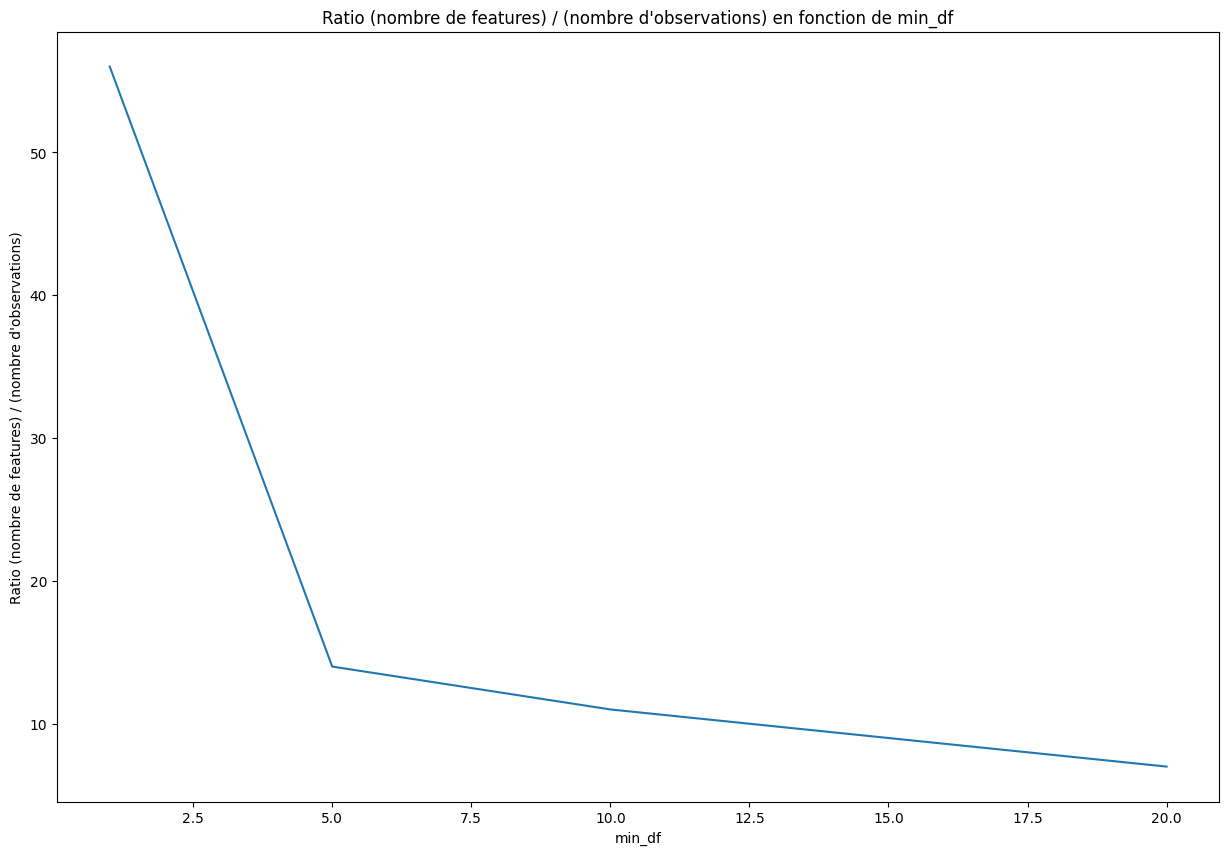

In [300]:
x = [1, 5, 10, 15, 20]
y = [56, 14, 11, 9, 7]
plt.figure(figsize=(15, 10))
plt.plot(x,y)
plt.title("Ratio (nombre de features) / (nombre d'observations) en fonction de min_df")
plt.xlabel("min_df")
plt.ylabel("Ratio (nombre de features) / (nombre d'observations)")